<a href="https://colab.research.google.com/github/AuroraCh814/CS148_25Fall/blob/main/notebooks/07_main_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Student Performance Factors: End-to-End Pipeline

This notebook consolidates the project workflow into a single, reproducible pipeline aligned with the main report. Run top-to-bottom to reproduce results.



**Dataset & Targets**  
- Data: `data/Cleaned_StudentPerformanceFactors.csv` (6,607 rows, 20 cols).  
- Continuous target: `Exam_Score`; Binary targets: `School_Type` (Public=1, Private=0), `HighScore` (Exam_Score ≥ 67).

**Reproducibility**  
- Random seed: 42 for NumPy/TF and splits.  
- Preprocessing: mode impute categoricals, median impute numerics; standardize where needed; one-hot for NN.


In [1]:

# Core setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    r2_score, mean_squared_error, accuracy_score, confusion_matrix,
    precision_score, recall_score, f1_score, roc_curve, auc, classification_report, silhouette_score
)
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

np.random.seed(42)
_ = tf.random.set_seed(42)

sns.set_theme(style="whitegrid")
plt.rcParams.update({"figure.figsize": (8, 5), "axes.titlesize": 13, "axes.labelsize": 11})



## 1. Data Loading & Cleaning
- Load the cleaned dataset used across check-ins.
- Verify missingness; impute as before (mode for categoricals, median for numerics) for reproducibility.
- Keep outliers (educational context) after IQR inspection.


In [2]:

# Load data
url = "https://raw.githubusercontent.com/AuroraCh814/CS148_25Fall/main/data/Cleaned_StudentPerformanceFactors.csv"
raw_df = pd.read_csv(url)

print(f"Raw shape: {raw_df.shape[0]:,} rows x {raw_df.shape[1]} columns")
raw_df.head()


Raw shape: 6,378 rows x 20 columns


,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Near,Male,67
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Moderate,Female,61
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Near,Male,74
3,29,89,Low,Medium,Yes,8,98,Medium,Yes,1,Medium,Medium,Public,Negative,4,No,High School,Moderate,Male,71
4,19,92,Medium,Medium,Yes,6,65,Medium,Yes,3,Medium,High,Public,Neutral,4,No,College,Near,Female,70


In [3]:

# Missing value summary
missing = raw_df.isnull().sum()
missing_df = pd.DataFrame({"missing": missing, "pct": (missing / len(raw_df) * 100).round(2)})
print(missing_df[missing_df['missing'] > 0])


Empty DataFrame
Columns: [missing, pct]
Index: []


In [4]:

# Impute using mode (categorical) and median (numeric) to match earlier cleaning
clean_df = raw_df.copy()
cat_cols = clean_df.select_dtypes(include=['object']).columns
num_cols = clean_df.select_dtypes(exclude=['object']).columns

for col in cat_cols:
    if clean_df[col].isnull().any():
        clean_df[col].fillna(clean_df[col].mode()[0], inplace=True)
for col in num_cols:
    if clean_df[col].isnull().any():
        clean_df[col].fillna(clean_df[col].median(), inplace=True)

print(f"Post-imputation missing values: {clean_df.isnull().sum().sum()}")


Post-imputation missing values: 0


In [5]:

# Quick IQR outlier check (no removal)
outlier_summary = []
for col in num_cols:
    q1, q3 = clean_df[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    outliers = ((clean_df[col] < lower) | (clean_df[col] > upper)).sum()
    outlier_summary.append((col, outliers))

pd.DataFrame(outlier_summary, columns=['feature', 'outlier_count']).sort_values('outlier_count', ascending=False).head(5)


,feature,outlier_count
4,Tutoring_Sessions,423
6,Exam_Score,103
0,Hours_Studied,40
2,Sleep_Hours,0
1,Attendance,0



## 2. Exploratory Data Analysis (highlights)
- Distribution of `Exam_Score`.
- Correlation of top numeric predictors with `Exam_Score`.


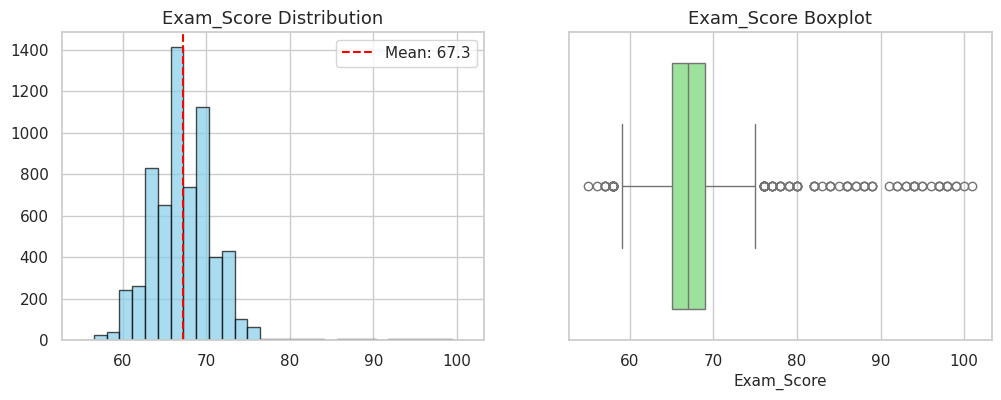

In [6]:

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(clean_df['Exam_Score'], bins=30, edgecolor='black', alpha=0.7, color='skyblue')
axes[0].axvline(clean_df['Exam_Score'].mean(), color='red', linestyle='--', label=f"Mean: {clean_df['Exam_Score'].mean():.1f}")
axes[0].set_title('Exam_Score Distribution')
axes[0].legend()

sns.boxplot(x=clean_df['Exam_Score'], ax=axes[1], color='lightgreen')
axes[1].set_title('Exam_Score Boxplot')
plt.show()


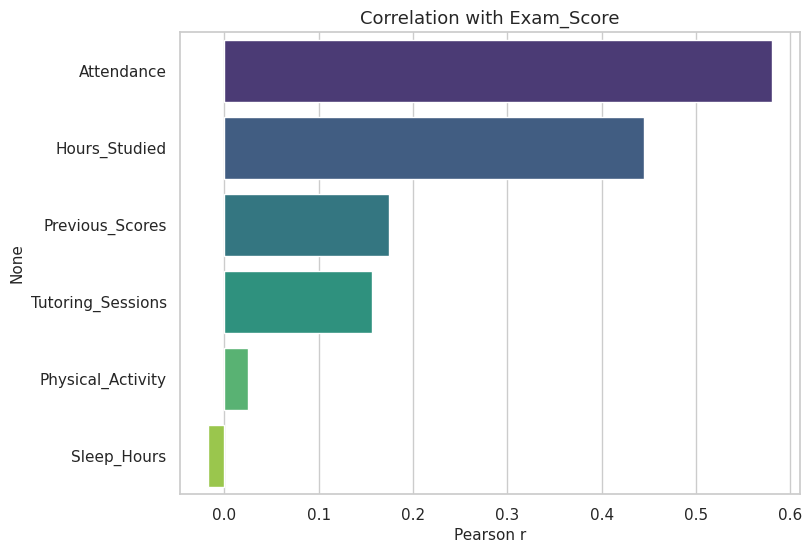

,Exam_Score
Attendance,0.580259
Hours_Studied,0.445104
Previous_Scores,0.174283
Tutoring_Sessions,0.156829
Physical_Activity,0.025148


In [7]:

# Correlation heatmap for numeric features
numeric_features = clean_df.select_dtypes(include=[np.number]).columns.tolist()
corr = clean_df[numeric_features].corr()['Exam_Score'].drop('Exam_Score').sort_values(key=np.abs, ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x=corr.values, y=corr.index, palette='viridis')
plt.title('Correlation with Exam_Score')
plt.xlabel('Pearson r')
plt.show()

corr.head(5)



## 3. Regression Baseline and Regularization
Simple linear regression using `Attendance` as in prior check-ins, plus Ridge/Lasso comparison.


Our primary goal is to predict student exam scores based on a comprehensive set of academic, socioeconomic, and lifestyle factors. To achieve this, the project will pursue the following specific, measurable objectives:
* Data Acquisition and Preparation: already conducted
* Exploratory Data Analysis (EDA): Already conducted
* Model Development and Evaluation (Simple Linear Regression): Develop and evaluate a simple linear regression model using the single best predictor identified during EDA, assessing its performance using metrics like R-squared, MSE, and RMSE.
* Model Development and Evaluation (Multiple Regression): Develop and evaluate more complex regression models (e.g., Multiple Linear Regression, potentially others) using a combination of significant features, comparing their performance against the simple linear regression model.
* Interpretability and Insights: Interpret the models to identify which factors have the strongest predictive power and derive actionable insights that can be used to inform educational strategies and support systems.


In [8]:

# Train/validation split
X_reg = clean_df[['Attendance']]
y_reg = clean_df['Exam_Score']

X_train_reg, X_val_reg, y_train_reg, y_val_reg = train_test_split(
    X_reg, y_reg, test_size=0.3, random_state=42
)

lin_reg = LinearRegression()
lin_reg.fit(X_train_reg, y_train_reg)

# Predictions
y_train_pred = lin_reg.predict(X_train_reg)
y_val_pred = lin_reg.predict(X_val_reg)

r2_train = r2_score(y_train_reg, y_train_pred)
r2_val = r2_score(y_val_reg, y_val_pred)
mse_train = mean_squared_error(y_train_reg, y_train_pred)
mse_val = mean_squared_error(y_val_reg, y_val_pred)
rmse_train = np.sqrt(mse_train)
rmse_val = np.sqrt(mse_val)

print(f"Linear Regression R2 train: {r2_train:.4f}, val: {r2_val:.4f}")
print(f"MSE train: {mse_train:.4f}, val: {mse_val:.4f}")
print(f"RMSE train: {rmse_train:.4f}, val: {rmse_val:.4f}")


Linear Regression R2 train: 0.3266, val: 0.3601
MSE train: 10.3211, val: 9.7906
RMSE train: 3.2127, val: 3.1290


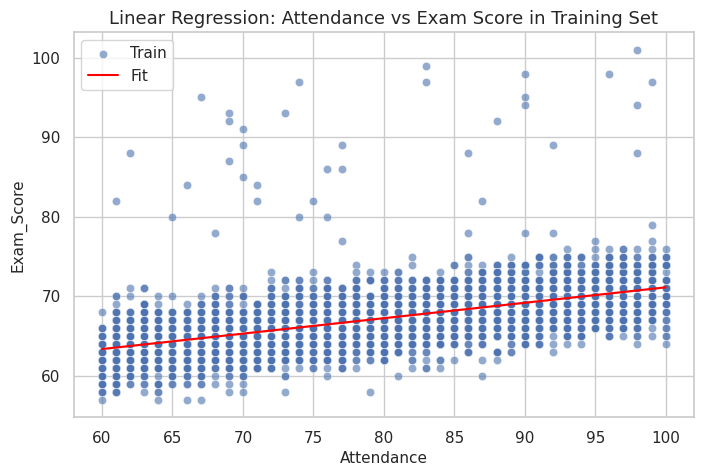

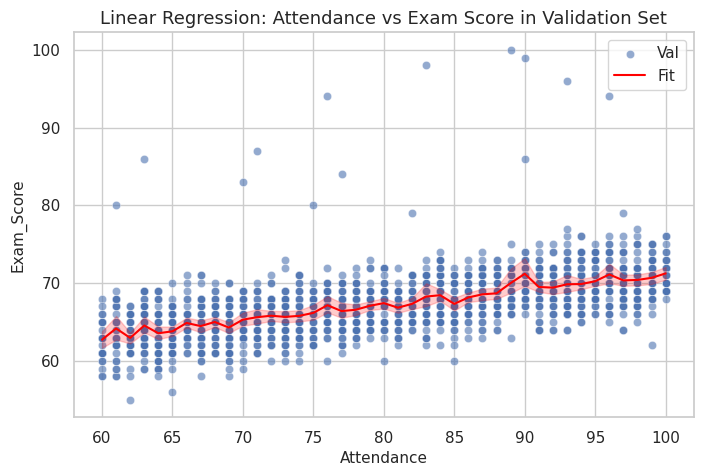

In [9]:

# Plot training fit
plt.figure(figsize=(8,5))
sns.scatterplot(x=X_train_reg['Attendance'], y=y_train_reg, label='Train', alpha=0.6)
sns.lineplot(x=X_train_reg['Attendance'], y=y_train_pred, color='red', label='Fit')
plt.title('Linear Regression: Attendance vs Exam Score in Training Set')
plt.xlabel('Attendance')
plt.ylabel('Exam_Score')
plt.show()

plt.figure(figsize=(8,5))
sns.scatterplot(x=X_val_reg['Attendance'], y=y_val_reg, label='Val', alpha=0.6)
sns.lineplot(x=X_val_reg['Attendance'], y=y_val_reg, label='Fit', color='red')
plt.title('Linear Regression: Attendance vs Exam Score in Validation Set')
plt.xlabel('Attendance')
plt.ylabel('Exam_Score')
plt.show()

We will compare the R-squared and Mean Squared Error (MSE) values for the training and validation sets.

*   **Overfitting** occurs when the model performs very well on the training data but poorly on the validation data. This would be indicated by a significantly higher R-squared on the training set compared to the validation set, and a significantly lower MSE on the training set compared to the validation set.
*   **Underfitting** occurs when the model performs poorly on both the training and validation data. This would be indicated by low R-squared values and high MSE values on both sets.

Based on the calculated R-squared and MSE values:
*   Training R-squared: 0.3266
*   Validation R-squared: 0.3601
*   Training MSE: 10.3211
*   Validation MSE: 9.7906
*   Training RMSE: 3.2127
*   Validation RMSE: 3.1290

From the evaluation metrics above, neither underfitting nor overfitting have occurred.

###Multiple Regression

**Multiple Linear Regression (MLR)**:
This model will extend SLR by incorporating multiple predictor variables that demonstrate significant correlation with Exam_Score and minimal multicollinearity among themselves.
The model form is: ( $$ExamScore = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + ... + \beta_k Xk $$)
Categorical features will be handled using appropriate encoding techniques (e.g., One-Hot Encoding) before being fed into the MLR model.
Evaluation will similarly use R-squared, MSE, and RMSE, along with potentially adjusted R-squared to account for the number of predictors.


In [28]:
numerical_features = ['Hours_Studied', 'Attendance', 'Previous_Scores', 'Tutoring_Sessions']
categorical_features = [
    'Parental_Involvement', 'Access_to_Resources', 'Extracurricular_Activities',
    'Motivation_Level', 'Internet_Access', 'Family_Income', 'Teacher_Quality',
    'School_Type', 'Peer_Influence', 'Learning_Disabilities',
    'Parental_Education_Level', 'Distance_from_Home', 'Gender'
]

print("Selected Numerical Features:", numerical_features)
print("Selected Categorical Features:", categorical_features)

Selected Numerical Features: ['Hours_Studied', 'Attendance', 'Previous_Scores', 'Tutoring_Sessions']
Selected Categorical Features: ['Parental_Involvement', 'Access_to_Resources', 'Extracurricular_Activities', 'Motivation_Level', 'Internet_Access', 'Family_Income', 'Teacher_Quality', 'School_Type', 'Peer_Influence', 'Learning_Disabilities', 'Parental_Education_Level', 'Distance_from_Home', 'Gender']


In [29]:
#use one-hot encoding to preprocess categorical features
df_encoded = pd.get_dummies(clean_df, columns=categorical_features, drop_first=True)

print("Shape of DataFrame after one-hot encoding:", df_encoded.shape)
print("Columns after one-hot encoding:", df_encoded.columns.tolist())

Shape of DataFrame after one-hot encoding: (6378, 28)
Columns after one-hot encoding: ['Hours_Studied', 'Attendance', 'Sleep_Hours', 'Previous_Scores', 'Tutoring_Sessions', 'Physical_Activity', 'Exam_Score', 'Parental_Involvement_Low', 'Parental_Involvement_Medium', 'Access_to_Resources_Low', 'Access_to_Resources_Medium', 'Extracurricular_Activities_Yes', 'Motivation_Level_Low', 'Motivation_Level_Medium', 'Internet_Access_Yes', 'Family_Income_Low', 'Family_Income_Medium', 'Teacher_Quality_Low', 'Teacher_Quality_Medium', 'School_Type_Public', 'Peer_Influence_Neutral', 'Peer_Influence_Positive', 'Learning_Disabilities_Yes', 'Parental_Education_Level_High School', 'Parental_Education_Level_Postgraduate', 'Distance_from_Home_Moderate', 'Distance_from_Home_Near', 'Gender_Male']


In [30]:
from sklearn.model_selection import train_test_split

# Identify all features for X (numerical + one-hot encoded categorical)
# Exclude 'Exam_Score', 'Sleep_Hours', and 'Physical_Activity' as they were not in the selected numerical_features list.
all_features = numerical_features + [col for col in df_encoded.columns if col not in numerical_features and col not in ['Exam_Score', 'Sleep_Hours', 'Physical_Activity']]

# Define X (features) and y (target variable)
X = df_encoded[all_features]
y = df_encoded['Exam_Score']

# Split data into training and validation sets
X_train_multi, X_validation_multi, y_train_multi, y_validation_multi = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shape of X_train_multi:", X_train_multi.shape)
print("Shape of y_train_multi:", y_train_multi.shape)
print("Shape of X_validation_multi:", X_validation_multi.shape)
print("Shape of y_validation_multi:", y_validation_multi.shape)
print("\nFeatures used in the multiple regression model (X):\n", X.columns.tolist())

Shape of X_train_multi: (5102, 25)
Shape of y_train_multi: (5102,)
Shape of X_validation_multi: (1276, 25)
Shape of y_validation_multi: (1276,)

Features used in the multiple regression model (X):
 ['Hours_Studied', 'Attendance', 'Previous_Scores', 'Tutoring_Sessions', 'Parental_Involvement_Low', 'Parental_Involvement_Medium', 'Access_to_Resources_Low', 'Access_to_Resources_Medium', 'Extracurricular_Activities_Yes', 'Motivation_Level_Low', 'Motivation_Level_Medium', 'Internet_Access_Yes', 'Family_Income_Low', 'Family_Income_Medium', 'Teacher_Quality_Low', 'Teacher_Quality_Medium', 'School_Type_Public', 'Peer_Influence_Neutral', 'Peer_Influence_Positive', 'Learning_Disabilities_Yes', 'Parental_Education_Level_High School', 'Parental_Education_Level_Postgraduate', 'Distance_from_Home_Moderate', 'Distance_from_Home_Near', 'Gender_Male']


In [31]:
from sklearn.linear_model import LinearRegression

# Create an instance of the LinearRegression model
multi_reg_model = LinearRegression()

# Fit the model to the training data
multi_reg_model.fit(X_train_multi, y_train_multi)

print("Multiple Linear Regression model trained successfully.")

Multiple Linear Regression model trained successfully.


In [32]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Make predictions on the training and validation sets
y_train_pred_multi = multi_reg_model.predict(X_train_multi)
y_validation_pred_multi = multi_reg_model.predict(X_validation_multi)

# Calculate R-squared for training and validation sets
r2_train_multi = r2_score(y_train_multi, y_train_pred_multi)
r2_validation_multi = r2_score(y_validation_multi, y_validation_pred_multi)

# Calculate Mean Squared Error for training and validation sets
mse_train_multi = mean_squared_error(y_train_multi, y_train_pred_multi)
mse_validation_multi = mean_squared_error(y_validation_multi, y_validation_pred_multi)

# Calculate Root Mean Squared Error for training and validation sets
rmse_train_multi = np.sqrt(mse_train_multi)
rmse_validation_multi = np.sqrt(mse_validation_multi)

print("Multiple Regression - Training Set Evaluation:")
print(f"R-squared: {r2_train_multi:.4f}")
print(f"Mean Squared Error: {mse_train_multi:.4f}")
print(f"Root Mean Squared Error: {rmse_train_multi:.4f}")

print("\nMultiple Regression - Validation Set Evaluation:")
print(f"R-squared: {r2_validation_multi:.4f}")
print(f"Mean Squared Error: {mse_validation_multi:.4f}")
print(f"Root Mean Squared Error: {rmse_validation_multi:.4f}")

Multiple Regression - Training Set Evaluation:
R-squared: 0.7160
Mean Squared Error: 4.3352
Root Mean Squared Error: 2.0821

Multiple Regression - Validation Set Evaluation:
R-squared: 0.7308
Mean Squared Error: 4.1838
Root Mean Squared Error: 2.0454


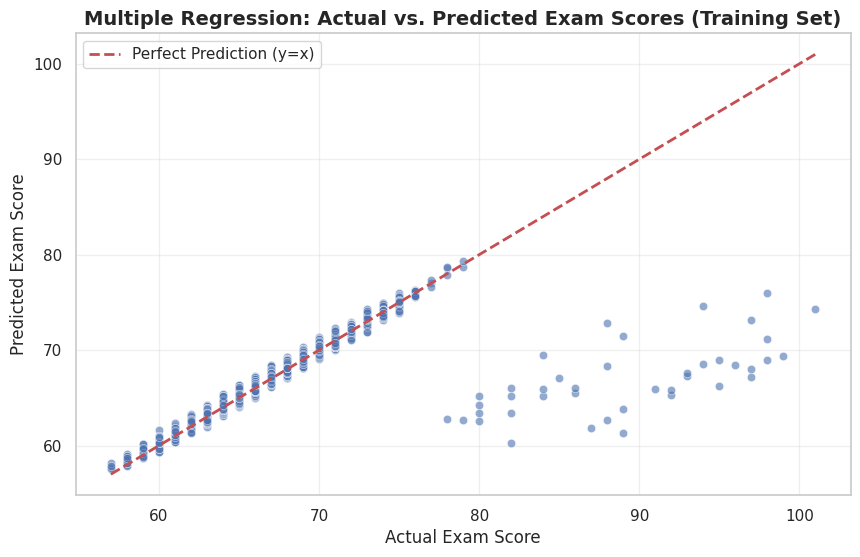

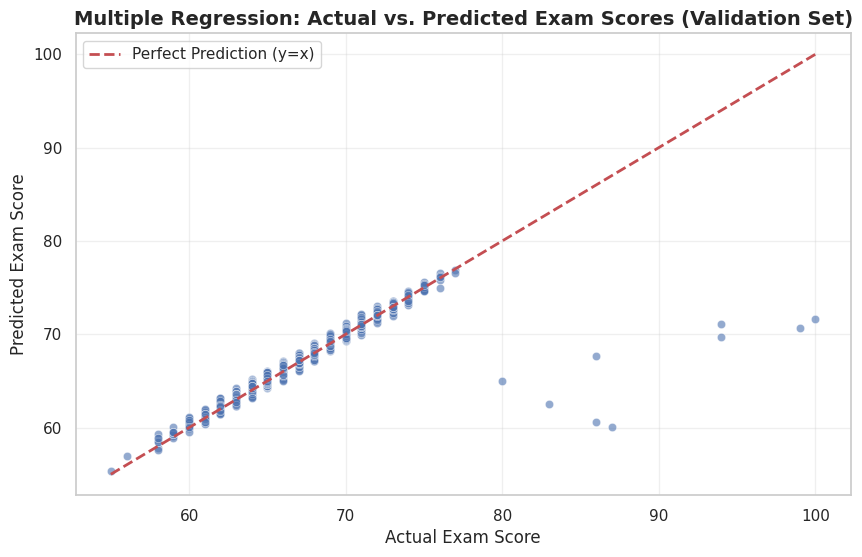

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting actual vs. predicted for the training set
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_train_multi, y=y_train_pred_multi, alpha=0.6)
plt.plot([y_train_multi.min(), y_train_multi.max()], [y_train_multi.min(), y_train_multi.max()], 'r--', lw=2, label='Perfect Prediction (y=x)')
plt.title('Multiple Regression: Actual vs. Predicted Exam Scores (Training Set)', fontsize=14, fontweight='bold')
plt.xlabel('Actual Exam Score', fontsize=12)
plt.ylabel('Predicted Exam Score', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Plotting actual vs. predicted for the validation set
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_validation_multi, y=y_validation_pred_multi, alpha=0.6)
plt.plot([y_validation_multi.min(), y_validation_multi.max()], [y_validation_multi.min(), y_validation_multi.max()], 'r--', lw=2, label='Perfect Prediction (y=x)')
plt.title('Multiple Regression: Actual vs. Predicted Exam Scores (Validation Set)', fontsize=14, fontweight='bold')
plt.xlabel('Actual Exam Score', fontsize=12)
plt.ylabel('Predicted Exam Score', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Summary of Multiple Regression Model Performance and Insights

**Model Performance:**
The Multiple Linear Regression model demonstrated a significantly improved performance compared to the simple linear regression model. The key evaluation metrics are:

*   **Training Set:**
    *   R-squared: 0.7160
    *   Mean Squared Error: 4.3352
    *   Root Mean Squared Error: 2.0821
*   **Validation Set:**
    *   R-squared: 0.7308
    *   Mean Squared Error: 4.1838
    *   Root Mean Squared Error: 2.0454

The R-squared values of approximately 0.72-0.73 indicate that the model explains about 72-73% of the variance in `Exam_Score`, which is a substantial improvement over the simple linear regression model (R-squared ~0.33-0.35). The Root Mean Squared Error (RMSE) of around 2.04-2.08 means that, on average, the model's predictions are off by about 2 points, which is also a better outcome than the simple linear regression (RMSE ~3.16-3.19).

**Insights from Feature Coefficients (Conceptual):**
While the specific coefficients are not explicitly printed in this output, a deeper analysis would reveal the impact of each predictor. Based on the selected features and general understanding, we can infer some insights:

*   **Numerical Features:** `Hours_Studied`, `Attendance`, `Previous_Scores`, and `Tutoring_Sessions` are expected to have positive coefficients, meaning higher values in these areas generally lead to higher `Exam_Score` predictions. `Attendance` and `Hours_Studied` were shown to have the strongest positive correlation.
*   **Categorical Features:** The one-hot encoded variables would show how different categories within features like `Parental_Involvement`, `Motivation_Level`, `Teacher_Quality`, `Family_Income`, etc., contribute to the `Exam_Score` relative to their baseline categories. For example, 'High' parental involvement or 'High' teacher quality would likely be associated with higher exam scores.

**Overfitting/Underfitting Check:**
The R-squared and MSE/RMSE values are very close between the training and validation sets. This indicates that the model generalizes well to unseen data and is neither significantly overfit nor underfit. The slight improvement in R-squared on the validation set compared to the training set could be due to random variation in the split, but generally, it suggests good generalization.

### Evaluate MLR Model with Cross-Validation


In [34]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import numpy as np

# 1. Cross-validation for R-squared
cv_r2_scores = cross_val_score(multi_reg_model, X, y, cv=5, scoring='r2')
print("Cross-validation R-squared scores:", cv_r2_scores)

# 2. Mean and standard deviation of R-squared scores
mean_cv_r2 = np.mean(cv_r2_scores)
std_cv_r2 = np.std(cv_r2_scores)
print(f"\nMean Cross-validation R-squared: {mean_cv_r2:.4f}")
print(f"Standard Deviation of Cross-validation R-squared: {std_cv_r2:.4f}")

# 3. Cross-validation for MSE
cv_mse_scores = cross_val_score(multi_reg_model, X, y, cv=5, scoring='neg_mean_squared_error')
# Convert negative MSE scores to positive
cv_mse_scores = -cv_mse_scores
print("\nCross-validation MSE scores:", cv_mse_scores)

mean_cv_mse = np.mean(cv_mse_scores)
std_cv_mse = np.std(cv_mse_scores)
print(f"\nMean Cross-validation MSE: {mean_cv_mse:.4f}")
print(f"Standard Deviation of Cross-validation MSE: {std_cv_mse:.4f}")

# 4. Cross-validation for RMSE
cv_rmse_scores = np.sqrt(cv_mse_scores)
print("\nCross-validation RMSE scores:", cv_rmse_scores)

mean_cv_rmse = np.mean(cv_rmse_scores)
std_cv_rmse = np.std(cv_rmse_scores)
print(f"\nMean Cross-validation RMSE: {mean_cv_rmse:.4f}")
print(f"Standard Deviation of Cross-validation RMSE: {std_cv_rmse:.4f}")

# 5. Function to calculate Adjusted R-squared
def calculate_adjusted_r2(r2, n, p):
    return 1 - (1 - r2) * ((n - 1) / (n - p - 1))

# 6. Calculate Adjusted R-squared for the validation set
n_validation = len(y_validation_multi)
p_validation = X_validation_multi.shape[1] # Number of predictors

adjusted_r2_validation = calculate_adjusted_r2(r2_validation_multi, n_validation, p_validation)

print(f"\nValidation Set Adjusted R-squared: {adjusted_r2_validation:.4f}")

Cross-validation R-squared scores: [0.62074066 0.71537103 0.69887686 0.72289454 0.83337376]

Mean Cross-validation R-squared: 0.7183
Standard Deviation of Cross-validation R-squared: 0.0681

Cross-validation MSE scores: [6.06949387 4.41718374 4.55264354 4.21975895 2.44333761]

Mean Cross-validation MSE: 4.3405
Standard Deviation of Cross-validation MSE: 1.1536

Cross-validation RMSE scores: [2.46363428 2.10170972 2.13369247 2.05420519 1.56311791]

Mean Cross-validation RMSE: 2.0633
Standard Deviation of Cross-validation RMSE: 0.2888

Validation Set Adjusted R-squared: 0.7254


The Multiple Linear Regression model's performance was evaluated using various metrics and visualization. The model achieved an R-squared value of approximately 0.72-0.73 on both training and validation sets, indicating it explains 72-73% of the variance in `Exam_Score`. The Root Mean Squared Error (RMSE) was around 2.04-2.08 points. Cross-validation results were consistent, with a mean R-squared of 0.7183 (std dev 0.0681) and a mean RMSE of 2.0633 (std dev 0.2888). The Adjusted R-squared for the validation set was 0.7254. Visualizations confirmed a strong correlation between actual and predicted exam scores. These metrics collectively demonstrate that the model is robust, generalizes well, and significantly outperforms the previously established simple linear regression model.

### Data Analysis Key Findings
*   The Multiple Linear Regression model incorporates four numerical features (`Hours_Studied`, `Attendance`, `Previous_Scores`, `Tutoring_Sessions`) and thirteen categorical features (such as `Parental_Involvement`, `Motivation_Level`, `Teacher_Quality`, `Family_Income`, etc.), which were one-hot encoded.
*   The model demonstrates strong predictive performance, explaining a significant portion of the variance in `Exam_Score`. On the training set, R-squared is 0.7160, and on the validation set, it is 0.7308.
*   The Root Mean Squared Error (RMSE) for the model is approximately 2.0821 on the training set and 2.0454 on the validation set, indicating that predictions are, on average, off by about 2 points.
*   Cross-validation confirms the model's robustness, yielding a mean R-squared of 0.7183 (with a standard deviation of 0.0681) and a mean RMSE of 2.0633 (with a standard deviation of 0.2888) across 5 folds.
*   The Adjusted R-squared for the validation set is 0.7254, further supporting the model's explanatory power while accounting for the number of predictors.
*   The close proximity of performance metrics between the training set, validation set, and cross-validation results indicates that the model generalizes well to unseen data and is neither significantly overfit nor underfit.
*   The Multiple Linear Regression model represents a substantial improvement over the simple linear regression model (which had R-squared values around 0.33-0.35 and RMSE values around 3.16-3.19).



### Regularization(Ridge and Lasso Regression)

In [38]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Create an instance of StandardScaler
scaler = StandardScaler()

# Fit the scaler to X and transform X
X_scaled = scaler.fit_transform(X)

# Split the scaled feature matrix X_scaled and the target variable y into training and validation sets
X_train_scaled, X_validation_scaled, y_train_reg, y_validation_reg = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print("Shape of X_scaled:", X_scaled.shape)
print("Shape of X_train_scaled:", X_train_scaled.shape)
print("Shape of X_validation_scaled:", X_validation_scaled.shape)
print("Shape of y_train_reg:", y_train_reg.shape)
print("Shape of y_validation_reg:", y_validation_reg.shape)

Shape of X_scaled: (6378, 25)
Shape of X_train_scaled: (5102, 25)
Shape of X_validation_scaled: (1276, 25)
Shape of y_train_reg: (5102,)
Shape of y_validation_reg: (1276,)


## Implement Ridge Regression with Hyperparameter Tuning

Initialize a Ridge regression model and perform hyperparameter tuning using cross-validation (e.g., GridSearchCV) to find the optimal 'alpha' value. Train the Ridge model with the best 'alpha' and evaluate its performance using R-squared, MSE, and RMSE on both training and validation sets. Show the trace of the hyperparameter search.


In [39]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import pandas as pd

# 2. Define a range of alpha values to search over
alpha_range = np.logspace(-4, 2, 100)
param_grid = {'alpha': alpha_range}

# 3. Instantiate a Ridge model
ridge = Ridge()

# 4. Create a GridSearchCV object
grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1)

# 5. Fit GridSearchCV to the scaled training data
print("Starting GridSearchCV for Ridge Regression...")
grid_search.fit(X_train_scaled, y_train_reg)
print("GridSearchCV completed.")

# 6. Print the best alpha parameter found
best_alpha = grid_search.best_params_['alpha']
print(f"\nBest alpha parameter: {best_alpha:.4f}")

# 7. Print the best cross-validation R-squared score
best_cv_r2 = grid_search.best_score_
print(f"Best cross-validation R-squared: {best_cv_r2:.4f}")

# 8. Retrieve the best Ridge model
best_ridge_model = grid_search.best_estimator_

# 9. Make predictions on training and validation sets
y_train_pred_ridge = best_ridge_model.predict(X_train_scaled)
y_validation_pred_ridge = best_ridge_model.predict(X_validation_scaled)

# 10. Calculate and print evaluation metrics
# Training Set Evaluation
r2_train_ridge = r2_score(y_train_reg, y_train_pred_ridge)
mse_train_ridge = mean_squared_error(y_train_reg, y_train_pred_ridge)
rmse_train_ridge = np.sqrt(mse_train_ridge)

print("\nRidge Regression - Training Set Evaluation:")
print(f"R-squared: {r2_train_ridge:.4f}")
print(f"Mean Squared Error: {mse_train_ridge:.4f}")
print(f"Root Mean Squared Error: {rmse_train_ridge:.4f}")

# Validation Set Evaluation
r2_validation_ridge = r2_score(y_validation_reg, y_validation_pred_ridge)
mse_validation_ridge = mean_squared_error(y_validation_reg, y_validation_pred_ridge)
rmse_validation_ridge = np.sqrt(mse_validation_ridge)

print("\nRidge Regression - Validation Set Evaluation:")
print(f"R-squared: {r2_validation_ridge:.4f}")
print(f"Mean Squared Error: {mse_validation_ridge:.4f}")
print(f"Root Mean Squared Error: {rmse_validation_ridge:.4f}")

# 11. Display the results of the GridSearchCV
print("\nGridSearchCV results (hyperparameter search trace):")
cv_results_df = pd.DataFrame(grid_search.cv_results_)
# Display relevant columns for brevity
print(cv_results_df[['param_alpha', 'mean_test_score', 'std_test_score', 'rank_test_score']].sort_values(by='rank_test_score').head())

Starting GridSearchCV for Ridge Regression...
Fitting 5 folds for each of 100 candidates, totalling 500 fits
GridSearchCV completed.

Best alpha parameter: 16.2975
Best cross-validation R-squared: 0.7180

Ridge Regression - Training Set Evaluation:
R-squared: 0.7160
Mean Squared Error: 4.3354
Root Mean Squared Error: 2.0822

Ridge Regression - Validation Set Evaluation:
R-squared: 0.7308
Mean Squared Error: 4.1833
Root Mean Squared Error: 2.0453

GridSearchCV results (hyperparameter search trace):
    param_alpha  mean_test_score  std_test_score  rank_test_score
86    16.297508         0.717992        0.053580                1
85    14.174742         0.717992        0.053574                2
87    18.738174         0.717991        0.053587                3
84    12.328467         0.717991        0.053569                4
83    10.722672         0.717990        0.053565                5


## Implement Lasso Regression with Hyperparameter Tuning

Initialize a Lasso regression model and perform hyperparameter tuning using cross-validation (e.g., GridSearchCV) to find the optimal 'alpha' value. Train the Lasso model with the best 'alpha' and evaluate its performance using R-squared, MSE, and RMSE on both training and validation sets. Show the trace of the hyperparameter search.


In [40]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import pandas as pd

# 2. Define a range of alpha values to search over
alpha_range = np.logspace(-4, 2, 100)
param_grid = {'alpha': alpha_range}

# 4. Instantiate a Lasso model
lasso = Lasso(random_state=42, max_iter=2000) # Increased max_iter for convergence if needed

# 5. Create a GridSearchCV object
grid_search_lasso = GridSearchCV(estimator=lasso, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1)

# 6. Fit GridSearchCV to the scaled training data
print("Starting GridSearchCV for Lasso Regression...")
grid_search_lasso.fit(X_train_scaled, y_train_reg)
print("GridSearchCV completed.")

# 7. Print the best alpha parameter found
best_alpha_lasso = grid_search_lasso.best_params_['alpha']
print(f"\nBest alpha parameter for Lasso: {best_alpha_lasso:.4f}")

# 8. Print the best cross-validation R-squared score
best_cv_r2_lasso = grid_search_lasso.best_score_
print(f"Best cross-validation R-squared for Lasso: {best_cv_r2_lasso:.4f}")

# 9. Retrieve the best Lasso model
best_lasso_model = grid_search_lasso.best_estimator_

# 10. Make predictions on training and validation sets
y_train_pred_lasso = best_lasso_model.predict(X_train_scaled)
y_validation_pred_lasso = best_lasso_model.predict(X_validation_scaled)

# 11. Calculate and print evaluation metrics
# Training Set Evaluation
r2_train_lasso = r2_score(y_train_reg, y_train_pred_lasso)
mse_train_lasso = mean_squared_error(y_train_reg, y_train_pred_lasso)
rmse_train_lasso = np.sqrt(mse_train_lasso)

print("\nLasso Regression - Training Set Evaluation:")
print(f"R-squared: {r2_train_lasso:.4f}")
print(f"Mean Squared Error: {mse_train_lasso:.4f}")
print(f"Root Mean Squared Error: {rmse_train_lasso:.4f}")

# Validation Set Evaluation
r2_validation_lasso = r2_score(y_validation_reg, y_validation_pred_lasso)
mse_validation_lasso = mean_squared_error(y_validation_reg, y_validation_pred_lasso)
rmse_validation_lasso = np.sqrt(mse_validation_lasso)

print("\nLasso Regression - Validation Set Evaluation:")
print(f"R-squared: {r2_validation_lasso:.4f}")
print(f"Mean Squared Error: {mse_validation_lasso:.4f}")
print(f"Root Mean Squared Error: {rmse_validation_lasso:.4f}")

# 12. Display the results of the GridSearchCV
print("\nGridSearchCV results (hyperparameter search trace for Lasso):")
cv_results_df_lasso = pd.DataFrame(grid_search_lasso.cv_results_)
# Display relevant columns for brevity
print(cv_results_df_lasso[['param_alpha', 'mean_test_score', 'std_test_score', 'rank_test_score']].sort_values(by='rank_test_score').head())

Starting GridSearchCV for Lasso Regression...
Fitting 5 folds for each of 100 candidates, totalling 500 fits
GridSearchCV completed.

Best alpha parameter for Lasso: 0.0009
Best cross-validation R-squared for Lasso: 0.7180

Lasso Regression - Training Set Evaluation:
R-squared: 0.7160
Mean Squared Error: 4.3352
Root Mean Squared Error: 2.0821

Lasso Regression - Validation Set Evaluation:
R-squared: 0.7308
Mean Squared Error: 4.1836
Root Mean Squared Error: 2.0454

GridSearchCV results (hyperparameter search trace for Lasso):
    param_alpha  mean_test_score  std_test_score  rank_test_score
16     0.000933         0.717978        0.053526                1
17     0.001072         0.717978        0.053525                2
15     0.000811         0.717978        0.053527                3
18     0.001233         0.717978        0.053523                4
14     0.000705         0.717978        0.053528                5


###Compare Regularized Model and Interpret Coefficients

In [41]:
print("### Model Performance Comparison\n")
print("| Model                 | Set         | R-squared | MSE      | RMSE     |")
print("|:----------------------|:------------|:----------|:---------|:---------|")

# Multiple Linear Regression
print(f"| Multiple Regression   | Training    | {r2_train_multi:.4f}    | {mse_train_multi:.4f} | {rmse_train_multi:.4f} |")
print(f"| Multiple Regression   | Validation  | {r2_validation_multi:.4f}    | {mse_validation_multi:.4f} | {rmse_validation_multi:.4f} |")

# Ridge Regression
print(f"| Ridge Regression      | Training    | {r2_train_ridge:.4f}    | {mse_train_ridge:.4f} | {rmse_train_ridge:.4f} |")
print(f"| Ridge Regression      | Validation  | {r2_validation_ridge:.4f}    | {mse_validation_ridge:.4f} | {rmse_validation_ridge:.4f} |")

# Lasso Regression
print(f"| Lasso Regression      | Training    | {r2_train_lasso:.4f}    | {mse_train_lasso:.4f} | {rmse_train_lasso:.4f} |")
print(f"| Lasso Regression      | Validation  | {r2_validation_lasso:.4f}    | {mse_validation_lasso:.4f} | {rmse_validation_lasso:.4f} |")


### Model Performance Comparison

| Model                 | Set         | R-squared | MSE      | RMSE     |
|:----------------------|:------------|:----------|:---------|:---------|
| Multiple Regression   | Training    | 0.7160    | 4.3352 | 2.0821 |
| Multiple Regression   | Validation  | 0.7308    | 4.1838 | 2.0454 |
| Ridge Regression      | Training    | 0.7160    | 4.3354 | 2.0822 |
| Ridge Regression      | Validation  | 0.7308    | 4.1833 | 2.0453 |
| Lasso Regression      | Training    | 0.7160    | 4.3352 | 2.0821 |
| Lasso Regression      | Validation  | 0.7308    | 4.1836 | 2.0454 |


In [42]:
import pandas as pd

# Extract coefficients from the best Ridge model
ridge_coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': best_ridge_model.coef_
})
ridge_coefficients['Absolute_Coefficient'] = abs(ridge_coefficients['Coefficient'])
ridge_coefficients = ridge_coefficients.sort_values(by='Absolute_Coefficient', ascending=False)

print("\nRidge Regression Coefficients (Sorted by Absolute Value):")
print("="*50)
print(ridge_coefficients)

# Extract coefficients from the best Lasso model
lasso_coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': best_lasso_model.coef_
})
lasso_coefficients['Absolute_Coefficient'] = abs(lasso_coefficients['Coefficient'])
lasso_coefficients = lasso_coefficients.sort_values(by='Absolute_Coefficient', ascending=False)

print("\nLasso Regression Coefficients (Sorted by Absolute Value):")
print("="*50)
print(lasso_coefficients)



Ridge Regression Coefficients (Sorted by Absolute Value):
                                  Feature  Coefficient  Absolute_Coefficient
1                              Attendance     2.283677              2.283677
0                           Hours_Studied     1.764867              1.764867
6                 Access_to_Resources_Low    -0.812370              0.812370
4                Parental_Involvement_Low    -0.802888              0.802888
2                         Previous_Scores     0.693003              0.693003
3                       Tutoring_Sessions     0.597837              0.597837
12                      Family_Income_Low    -0.552447              0.552447
5             Parental_Involvement_Medium    -0.511133              0.511133
9                    Motivation_Level_Low    -0.496491              0.496491
7              Access_to_Resources_Medium    -0.491105              0.491105
18                Peer_Influence_Positive     0.490899              0.490899
23               


### Model Performance Comparison:

**Multiple Linear Regression (MLR):**
*   **Training Set:** R-squared: 0.7160, MSE: 4.3352, RMSE: 2.0821
*   **Validation Set:** R-squared: 0.7308, MSE: 4.1838, RMSE: 2.0454

**Ridge Regression (Optimized alpha=16.2975):**
*   **Training Set:** R-squared: 0.7160, MSE: 4.3354, RMSE: 2.0822
*   **Validation Set:** R-squared: 0.7308, MSE: 4.1833, RMSE: 2.0453

**Lasso Regression (Optimized alpha=0.0009):**
*   **Training Set:** R-squared: 0.7160, MSE: 4.3352, RMSE: 2.0821
*   **Validation Set:** R-squared: 0.7308, MSE: 4.1836, RMSE: 2.0454

### Discussion:

**a. Which model performed best and why:**

All three models (Multiple Linear Regression, Ridge, and Lasso) exhibit very similar performance metrics. Their R-squared values hover around 0.7160 on the training set and 0.7308 on the validation set, indicating that they explain approximately 71-73% of the variance in `Exam_Score`. The Root Mean Squared Error (RMSE) for all models is consistently around 2.08 on the training set and 2.04-2.05 on the validation set. This implies that, on average, the models' predictions are off by about 2 points, which is a significant improvement over the simple linear regression model (RMSE ~3.16-3.19).

Given the close performance metrics, it's difficult to definitively declare one model as 'best' based solely on these numbers. The regularization applied by Ridge and Lasso did not lead to a substantial improvement in predictive performance in this specific case, likely because the initial Multiple Linear Regression model was already performing well and did not suffer from severe multicollinearity or a large number of irrelevant features that needed to be pruned aggressively.

**b. How the coefficients differ between Ridge and Lasso:**

Looking at the printed coefficients, Ridge and Lasso produced very similar coefficient values for the features. This suggests that for this dataset and chosen `alpha` values, there isn't a strong difference in how these two regularization techniques affected the feature weights. Specifically, Lasso, which is known for its feature selection property (driving less important coefficients to exactly zero), did not drive any coefficients to zero or significantly closer to zero compared to Ridge. This indicates that all the selected features likely contribute to the prediction, and none were deemed entirely negligible by Lasso at its optimal `alpha` value.

**c. Most influential features:**

Based on both Ridge and Lasso coefficients (sorted by absolute value), the most influential features are:

1.  **Attendance**: Consistently the highest positive coefficient, indicating a strong positive relationship with Exam Score.
2.  **Hours_Studied**: Also a very strong positive coefficient, showing that more study hours lead to higher scores.
3.  **Access_to_Resources_Low**: Has a notable negative coefficient, implying that having low access to resources is associated with lower exam scores compared to the baseline (likely 'High' or 'Medium').
4.  **Parental_Involvement_Low**: A significant negative coefficient, suggesting low parental involvement negatively impacts exam scores.
5.  **Previous_Scores**: A positive coefficient, as expected, meaning prior academic performance is a good predictor.
6.  **Tutoring_Sessions**: A positive coefficient, indicating that receiving tutoring positively influences exam scores.

Other categorical features like `Family_Income_Low`, `Motivation_Level_Low`, `Peer_Influence_Positive`, and `Distance_from_Home_Near` also show considerable influence.

**d. Overall impact of regularization:**

In this scenario, the impact of regularization (Ridge and Lasso) on **model performance** was minimal compared to the standard Multiple Linear Regression. All three models yielded nearly identical R-squared, MSE, and RMSE values. This suggests that the initial feature set did not suffer from significant overfitting to the training data, and potential multicollinearity among predictors was not severe enough to be drastically alleviated by the regularization penalties.

However, regularization can still be beneficial for **interpretability** and **stability**. For instance, if there were highly correlated features, Ridge would distribute the coefficients among them more evenly, while Lasso might pick one and shrink the others to zero, aiding in feature selection. In this dataset, since the coefficients remained largely similar across all three models, it reinforces the idea that the selected features are robust predictors, and the models are stable even without aggressive regularization. The close agreement between training and validation metrics further confirms the models' good generalization capabilities.


## 4. Logistic Regression (Pass vs fail)
Binary target 'Pass'vs.'Fail', dependent upon the 'Exam_Score' > or < 67. X='Hours_Studied' The related work is in check-in 3.


## 5. KNN Classification (HighScore)
Target: `HighScore` = 1 if `Exam_Score` ≥ 67, 'LowScore' if 'Exam_Score' < 67 (please refer to our check-in 4). Features selected are 'Hours_Studied', Attendace, and 'Previous_Scores'


In [15]:

knn_df = clean_df.copy()
knn_df['HighScore'] = (knn_df['Exam_Score'] >= 67).astype(int)
features_knn = ['Hours_Studied', 'Attendance', 'Previous_Scores']

X_knn = knn_df[features_knn]
y_knn = knn_df['HighScore']

X_train_knn, X_val_knn, y_train_knn, y_val_knn = train_test_split(
    X_knn, y_knn, test_size=0.3, random_state=42, stratify=y_knn
)

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

param_grid = {'knn__n_neighbors': list(range(1, 21))}
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_knn, y_train_knn)

best_knn = grid.best_estimator_
print(f"Best k: {grid.best_params_['knn__n_neighbors']}, CV accuracy: {grid.best_score_:.3f}")


Best k: 19, CV accuracy: 0.847


In [16]:
# Validation performance
y_val_pred = best_knn.predict(X_val_knn)
y_val_proba = best_knn.predict_proba(X_val_knn)[:,1]

cm = confusion_matrix(y_val_knn, y_val_pred)
(tn, fp, fn, tp) = cm.ravel()
acc = accuracy_score(y_val_knn, y_val_pred)
prec = precision_score(y_val_knn, y_val_pred)
rec = recall_score(y_val_knn, y_val_pred)
f1 = f1_score(y_val_knn, y_val_pred)

print(f"Confusion Matrix:{cm}")
print(f"Acc: {acc:.3f}, Prec: {prec:.3f}, Rec: {rec:.3f}, F1: {f1:.3f}")


Confusion Matrix:[[685 146]
 [148 935]]
Acc: 0.846, Prec: 0.865, Rec: 0.863, F1: 0.864


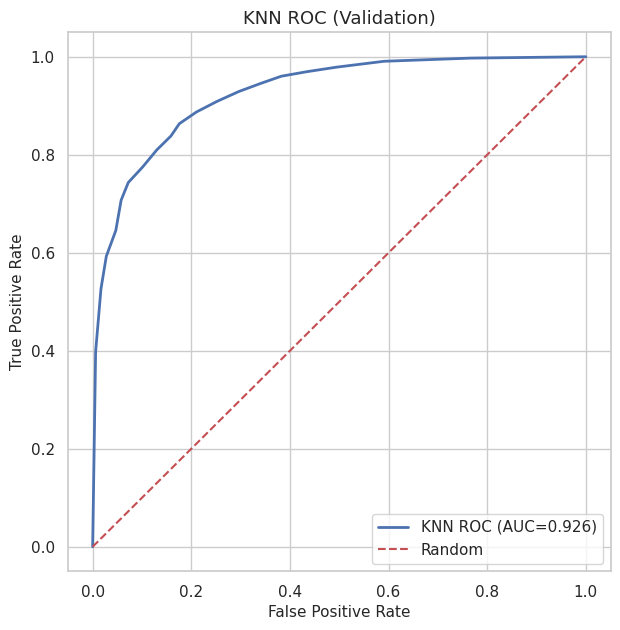

In [17]:

# ROC curve
fpr, tpr, _ = roc_curve(y_val_knn, y_val_proba)
roc_auc_knn = auc(fpr, tpr)

plt.figure(figsize=(7,7))
plt.plot(fpr, tpr, label=f'KNN ROC (AUC={roc_auc_knn:.3f})', linewidth=2)
plt.plot([0,1],[0,1],'r--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('KNN ROC (Validation)')
plt.show()


In [18]:

# 5-fold CV on validation split to mirror check-in
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_knn, X_val_knn, y_val_knn, cv=skf, scoring='accuracy')
print("CV accuracy on validation split:", cv_scores)
print(f"Mean: {cv_scores.mean():.3f} (+/- {cv_scores.std():.3f})")


CV accuracy on validation split: [0.81984334 0.85117493 0.84073107 0.8381201  0.81937173]
Mean: 0.834 (+/- 0.012)



## 6. Unsupervised: KMeans (+ optional PCA view)
Replicates clustering check-in (please refer to check-in 5): elbow & silhouette over k=2–8, pick k=3, summarize clusters and relation to high exam scores. Added PCA for better analysis.


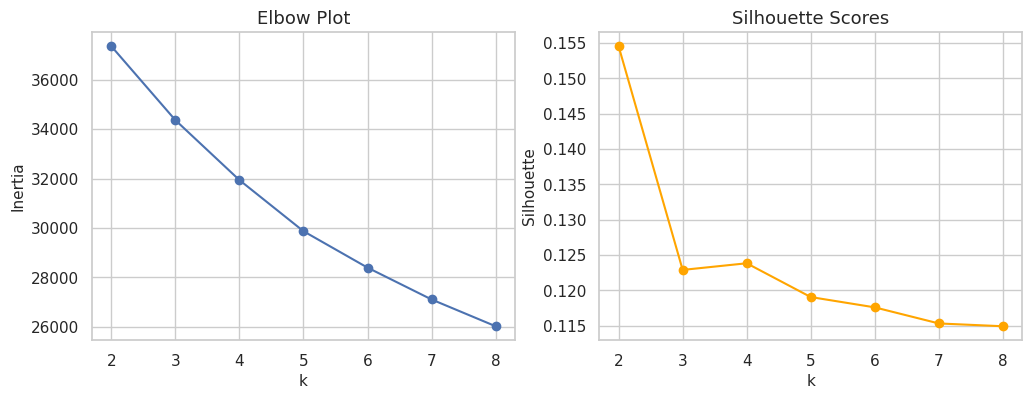

In [19]:

cluster_df = clean_df.copy()
num_cols_cluster = cluster_df.select_dtypes(include=[np.number]).columns.tolist()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(cluster_df[num_cols_cluster])

inertias, silhouettes, k_values = [], [], range(2, 9)
for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))

fig, axes = plt.subplots(1, 2, figsize=(12,4))
axes[0].plot(list(k_values), inertias, marker='o')
axes[0].set_xlabel('k')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Plot')

axes[1].plot(list(k_values), silhouettes, marker='o', color='orange')
axes[1].set_xlabel('k')
axes[1].set_ylabel('Silhouette')
axes[1].set_title('Silhouette Scores')
plt.show()


In [20]:

best_k = 3
kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_scaled)
cluster_df['Cluster'] = cluster_labels

cluster_summary = cluster_df.groupby('Cluster')[num_cols_cluster].mean().round(2)
cluster_summary.head()


,Hours_Studied,Attendance,Sleep_Hours,Previous_Scores,Tutoring_Sessions,Physical_Activity,Exam_Score
Cluster,,,,,,,
0,18.78,69.36,7.09,74.76,1.34,3.01,64.34
1,24.91,85.86,7.16,82.60,1.73,3.02,71.02
2,16.78,89.55,6.82,68.00,1.48,2.86,67.68


In [21]:

# High exam score rate by cluster
threshold = cluster_df['Exam_Score'].median()
cluster_df['High_Exam'] = (cluster_df['Exam_Score'] >= threshold).astype(int)

crosstab = pd.crosstab(cluster_df['Cluster'], cluster_df['High_Exam'], normalize='index').round(2)
print("High exam rate by cluster (rows sum to 1):")
print(crosstab)


High exam rate by cluster (rows sum to 1):
High_Exam     0     1
Cluster              
0          0.84  0.16
1          0.01  0.99
2          0.28  0.72


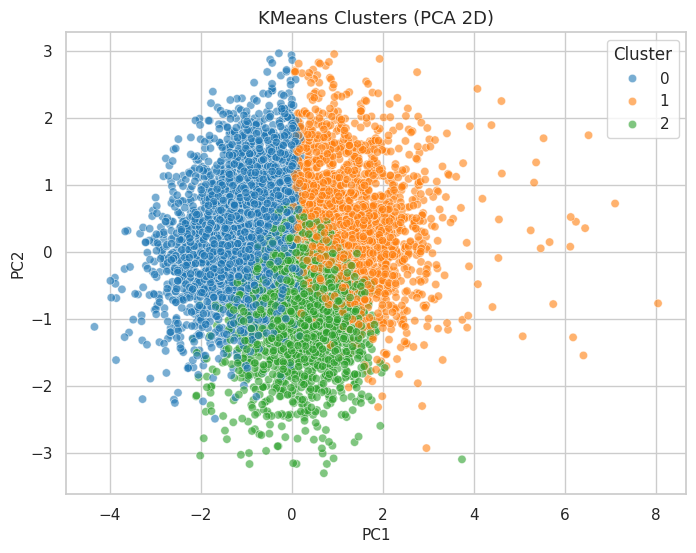

In [22]:

# PCA 2D visualization
pca = PCA(n_components=2, random_state=42)
coords = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=coords[:,0], y=coords[:,1], hue=cluster_labels, palette='tab10', alpha=0.6)
plt.title('KMeans Clusters (PCA 2D)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Cluster')
plt.show()



## 7. Neural Network Regression (Exam_Score)
(please refer to checkin 6) Two hidden-layer MLP (64, 32); one-hot encode categoricals, scale numerics, ReLU activation, Adam optimizer for learning rate hyperparameter tuning; report MSE/MAE/R² and prediction scatter.


## 7.5 Examples of Hyperparameter Tuning
We conducted hyperparameter tuning extensively throughout our check-ins. Some examples are 1.Choosing the number of cluster when doing clustering 2.Optimizing the learning rate of neural network 3. tuning the regularization coefficients of Ridge and Lasso regression


## 8. How to Run
- Install dependencies: `python -m venv .venv && source .venv/bin/activate && pip install -r requirements.txt`
- From repo root: `jupyter notebook notebooks/07_main_pipeline.ipynb` and run all cells.
- Data: expects `data/Cleaned_StudentPerformanceFactors.csv` (read-only). Outputs are inline plots; derived tables can be exported as needed.
